<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/combinedVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

bands = [(0, 15), (15, 30), (30, 50), (50, 70), (70, 85), (85, 100)]

In [2]:
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [96]:
def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0], activation='sigmoid')(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


In [88]:
def generate_spectrum(n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1,):
    x = np.linspace(0, 1, n_bins)  # Avoid zero to prevent division by zero in power law
    spectrum = np.zeros_like(x)

    # Add power law component
    power_law_exponent = np.random.uniform(pmin, pmax)
    spectrum += np.power(x+0.3, power_law_exponent)

    # Add Gaussian peaks
    n = np.random.randint(1,n_peaks+1)
    for _ in range(n):
        amplitude = np.random.uniform(0.1, 1.0)
        mean = np.random.uniform(0.2, 0.8)
        std_dev = np.random.uniform(0.01, 0.1)
        amplitude = amplitude * spectrum[int(mean*n_bins)]
        spectrum += amplitude * np.exp(-0.5 * ((x - mean) / std_dev)**2)

    # Add noise
    noise = np.random.normal(scale=noise_level, size=n_bins)
    spectrum += noise

    return x, spectrum

# Integrate the spectrum over given band passes
def integrate_band_passes(spectrum, band_edges):
    integrals = []
    for (start, end) in band_edges:
        band_val = np.nansum(spectrum[start:end]) / (end-start+1)
        integrals.append(band_val)
    return np.array(integrals)

# Generate a dataset
def generate_dataset(n_samples=1000, n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1, band_edges=None):
    if band_edges is None:
        # Define 6 band pass edges (as indices for simplicity)
        band_edges = bands

    spectra = []
    integrals = []
    for _ in range(n_samples):
        _, spectrum = generate_spectrum(n_bins=n_bins, n_peaks=n_peaks, noise_level=noise_level, pmin=pmin, pmax=pmax)
        spectrum /= np.max(spectrum)
        spectra.append(spectrum)
        integrals.append(integrate_band_passes(spectrum, band_edges))

    spectra = np.array(spectra, dtype=np.float32)
    integrals = np.array(integrals, dtype=np.float32)

    return spectra, integrals

# Normalize the spectra and integrals
def normalize(data):
    h = np.max(data, axis=1)[:,None]
    l = np.min(data, axis=1)[:,None]
    return data/h


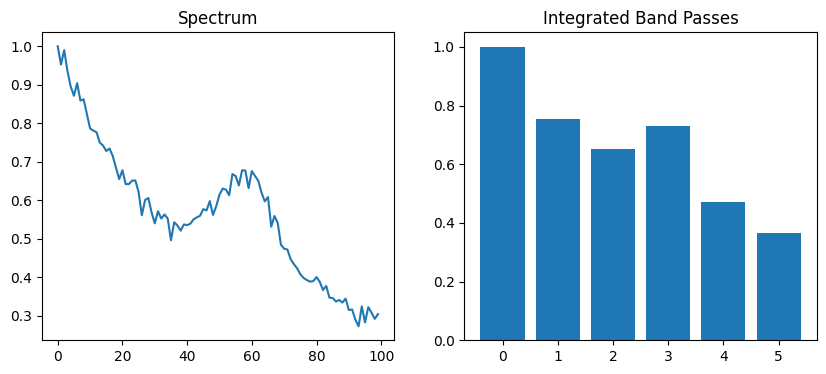

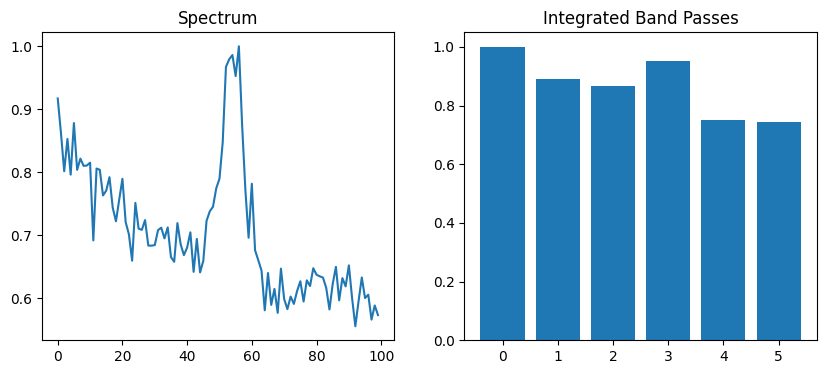

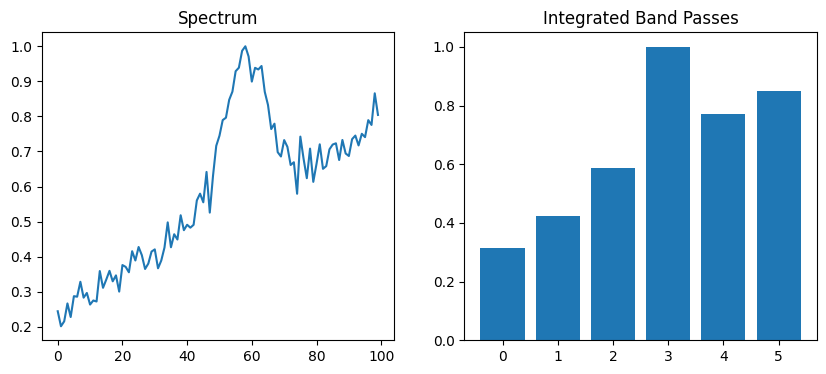

In [5]:
n_samples = 100000
n_bins = 100
n_peaks = 1
spectra, integrals = generate_dataset(n_samples, n_bins, n_peaks)
#spectra, integrals = generate_dataset(n_samples, n_bins, 1, noise_level=0, pmin=0)

# Normalize data
spectra = normalize(spectra)
integrals = normalize(integrals)

# Visualize some examples
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(spectra[i])
    plt.title('Spectrum')
    plt.subplot(1, 2, 2)
    plt.bar(range(len(integrals[i])), integrals[i])
    plt.title('Integrated Band Passes')
    plt.show()

In [97]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(100,))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                    keras.losses.mean_squared_error(data_out, reconstruction),
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [108]:
bpvae = BandPassVAE(6,3, beta=0.0001)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=200, batch_size=128, validation_split=0.2)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_519']
Received: inputs=Tensor(shape=(128, 6))
  warnings.warn(msg)


617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 4.6855 - loss: 0.0191 - reconstruction_loss: 0.0186((<tf.Tensor 'data:0' shape=(None, 6) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 100) dtype=float32>),)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_519']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 4.7369 - loss: 0.0190 - reconstruction_loss: 0.0185 - val_kl_loss: 8.1692 - val_loss: 0.0304 - val_reconstruction_loss: 0.0296
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 8.5695 - loss: 0.0106 - reconstruction_loss: 0.0097 - val_kl_loss: 8.4844 - val_loss: 0.0279 - val_reconstruction_loss: 0.0270
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 8.2468 - loss: 0.0100 - reconstruction_loss: 0.0091 - val_kl_loss: 8.4248 - val_loss: 0.0268 - val_reconstruction_loss: 0.0260
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 10.0305 - loss: 0.0082 - reconstruction_loss: 0.0072 - val_kl_loss: 10.9146 - val_loss: 0.0188 - val_reconstruction_loss: 0.0177
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 10.9815 - loss: 0.0069 - reconstruction_loss: 0.0058 - val_kl_loss: 11.1774 - val_loss: 0.0175 - val_reconstruction_loss: 0.0164
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step 

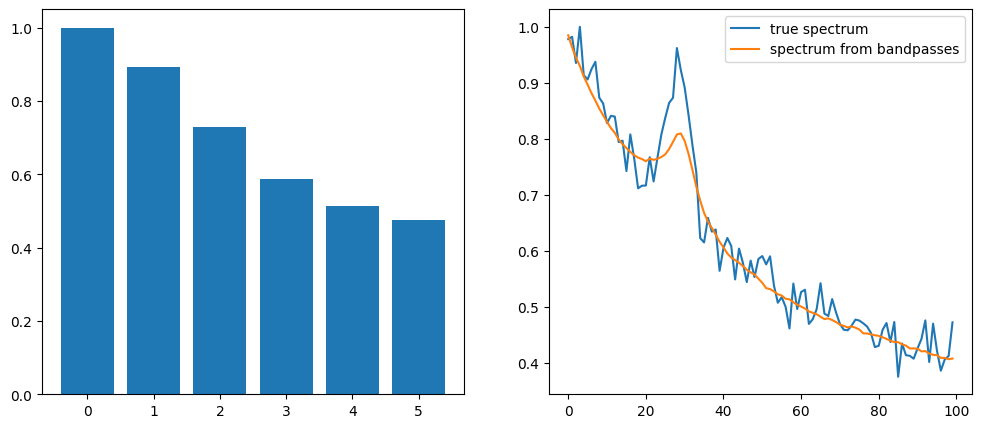

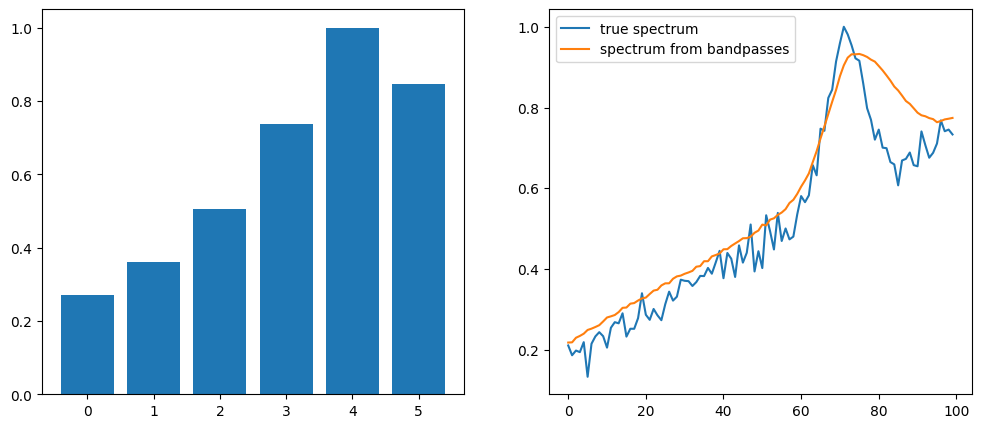

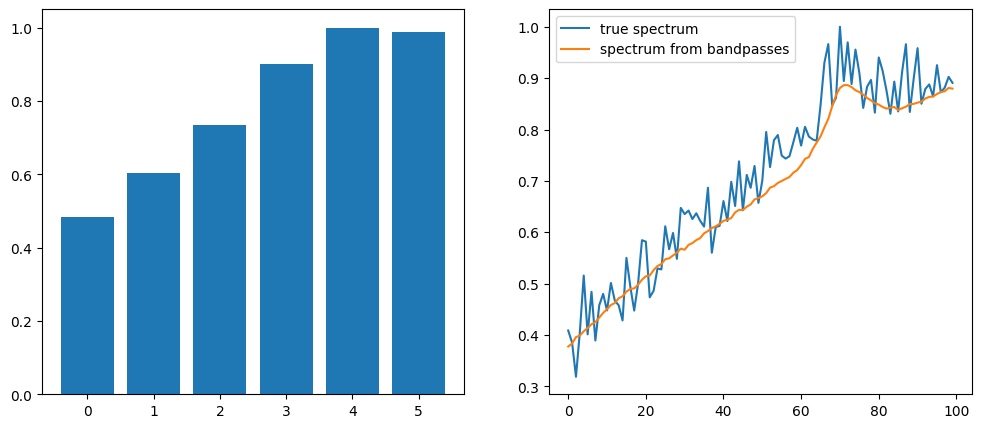

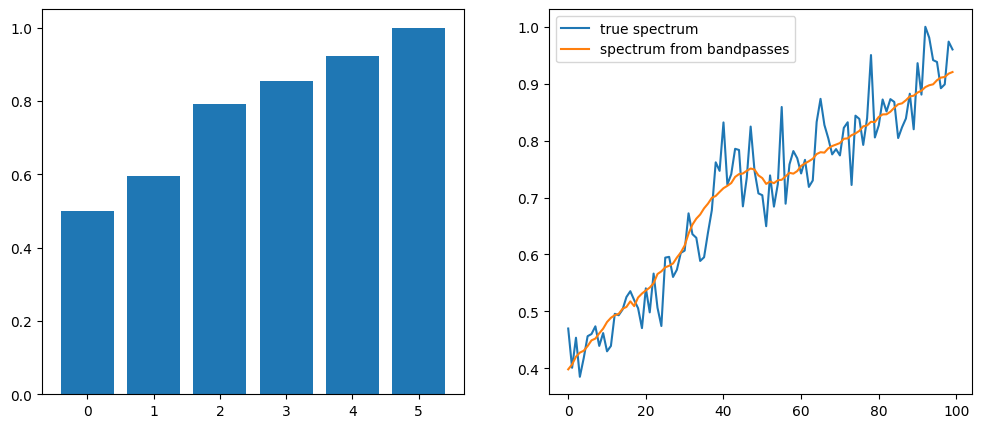

In [115]:
ii=1026
for ii in [1026, 1027, 1028, 1029]:
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,6)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].bar(range(len(integrals[ii])), integrals[ii])
    plt.legend()
    plt.show()